# Modeling neighborhoods and neighborhood types

In the urban studies, the subfield of **geodemographics** focuses on the use of cluster analysis to identify a typology of prototypical neighborhoods in a study region. Meanwhile, the subfield of **regionalization** focuses on identifying contiguous groups of spatial units whose internal attribute structure is relatively homogenous. Whereas geodemographics are concerned primarily with summarizing and categorizing neighborhoods, regionalization is concerned primarily with identifying and delineating neighborhoods. 

geosnap supports both of these goals by providing classic and spatial clustering algorithms as methods on the `Community` object

In [1]:
from geosnap.data import Community, data_store as store

import matplotlib.pyplot as plt
import seaborn as sns
import sys, os

sns.set_context('notebook')

import warnings
warnings.filterwarnings("ignore")

/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
/Users/knaaptime/anaconda3/envs/geosnap/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


## Modeling neighborhood types

To facilitate geodemographic and other neighborhood typologies, the `geosnap.analyze` module provides the `cluster` function, which is also implemented as a method on the `Community` class.

`cluster` takes a list of columns/variables, a clustering algorithm, and a number of clusters. It handles temporal clustering by splitting the dataset into decades and standardizing each variable, then re-pooling all the time periods back together before running the clustering algorithm on the full set of observations. This allows the distribution of each variable to evolve over time. It also allows neighborhood variables to move through different positions in the distrbution while providing a consistent set of clusters across time periods

In [2]:
columbusfips=store.msas()[store.msas().name.str.startswith('Columbus, OH')].geoid.values[0]

In [3]:
columbus = Community.from_ltdb(msa_fips=columbusfips)

In [4]:
columbus.cluster(columns=['median_household_income', 'p_poverty_rate', 'p_edu_college_greater', 'p_unemployment_rate'], method='ward')

In [5]:
# create a little helper function for plotting a time-series

import matplotlib.pyplot as plt

def plot(community, column, cmap):
    fig, axs = plt.subplots(1,3, figsize=(15,5))
    axs=axs.flatten()

    community.gdf[community.gdf.year==1990].dropna(subset=[column]).plot(column=column, cmap=cmap, ax=axs[0])
    axs[0].axis('off')
    axs[0].set_title('1990')

    community.gdf[community.gdf.year==2000].dropna(subset=[column]).plot(column=column, cmap=cmap, ax=axs[1])
    axs[1].axis('off')
    axs[1].set_title('2000')

    community.gdf[community.gdf.year==2010].dropna(subset=[column]).plot(column=column, cmap=cmap, ax=axs[2])
    axs[2].axis('off')
    axs[2].set_title('2010')
    
    fig.suptitle(column, fontsize=14, fontweight='bold')


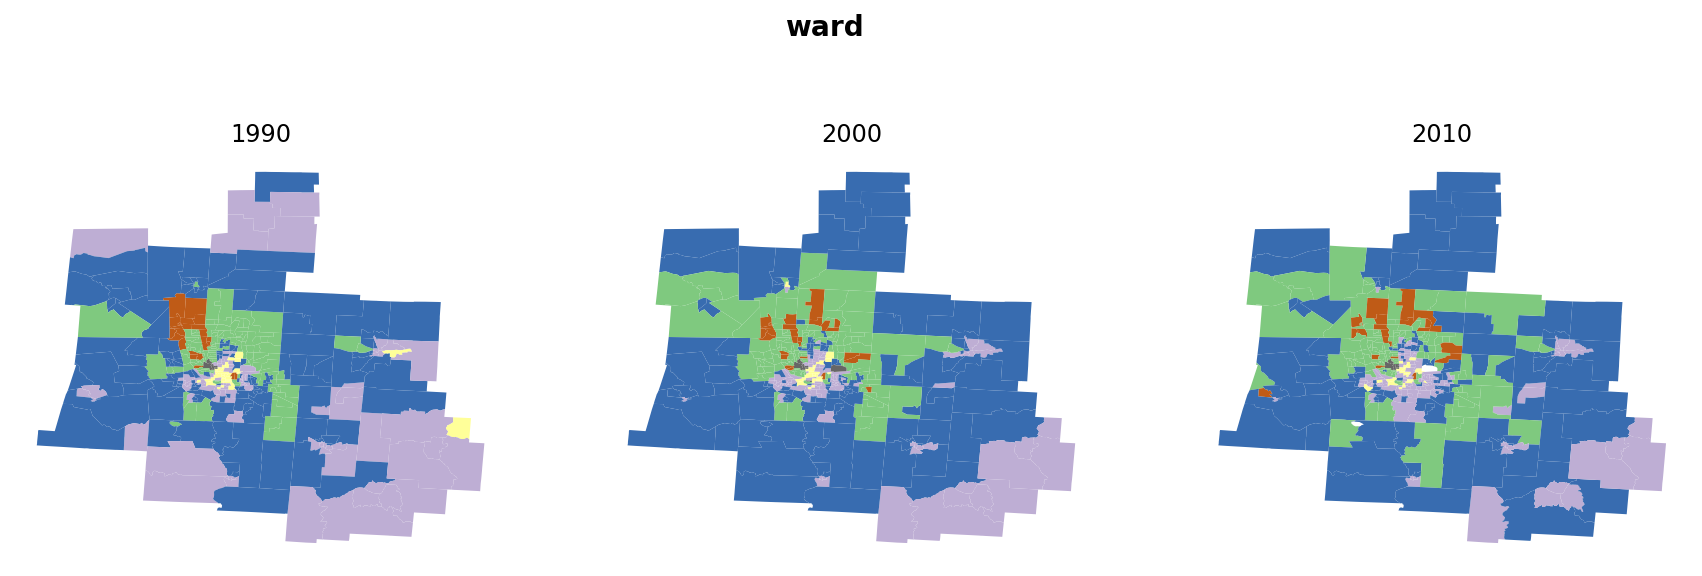

In [6]:
plot(columbus, 'ward', 'Accent')

`cluster` returns a `Community` class with cluster labels appended as a new column on the underlying geodataframe. This makes it simple to visualize how the clusters have evolved in space over time

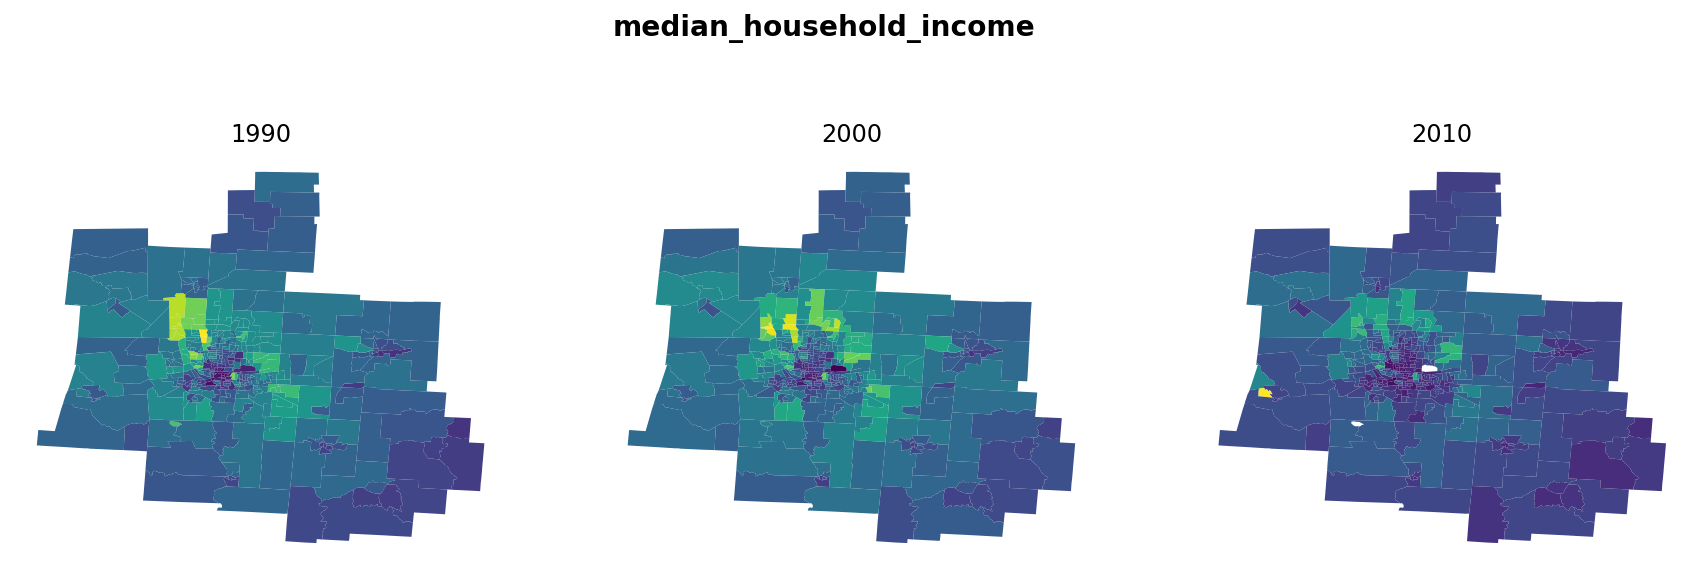

In [7]:
plot(columbus, 'median_household_income', 'viridis')

Since cluster labels are appended to the input database, it's also simple to compute and visualize statistics by cluster, even for variables that weren't used to derive the clusters

In [8]:
columbus.gdf.groupby('ward')['p_nonhisp_white_persons'].median()

ward
0    92.849963
1    81.712362
2    26.917546
3    95.743874
4    94.202012
5    82.809803
Name: p_nonhisp_white_persons, dtype: float64

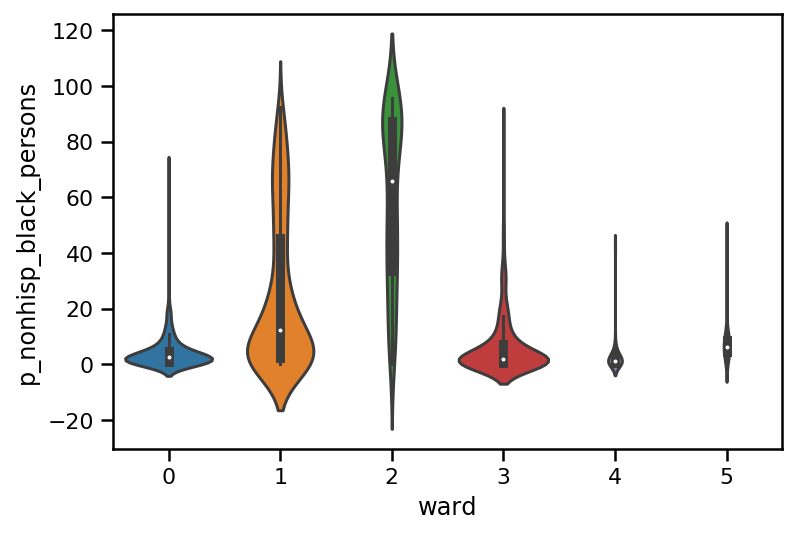

In [9]:
sns.violinplot(x="ward", y="p_nonhisp_black_persons", data=columbus.gdf, scale='count')

In [10]:
types = ['kmeans', 'affinity_propagation', 'gaussian_mixture', 'spectral', 'hdbscan']

Since there are many different clusting algorithms available, you can examine how their solutions differ for the same set of input variables

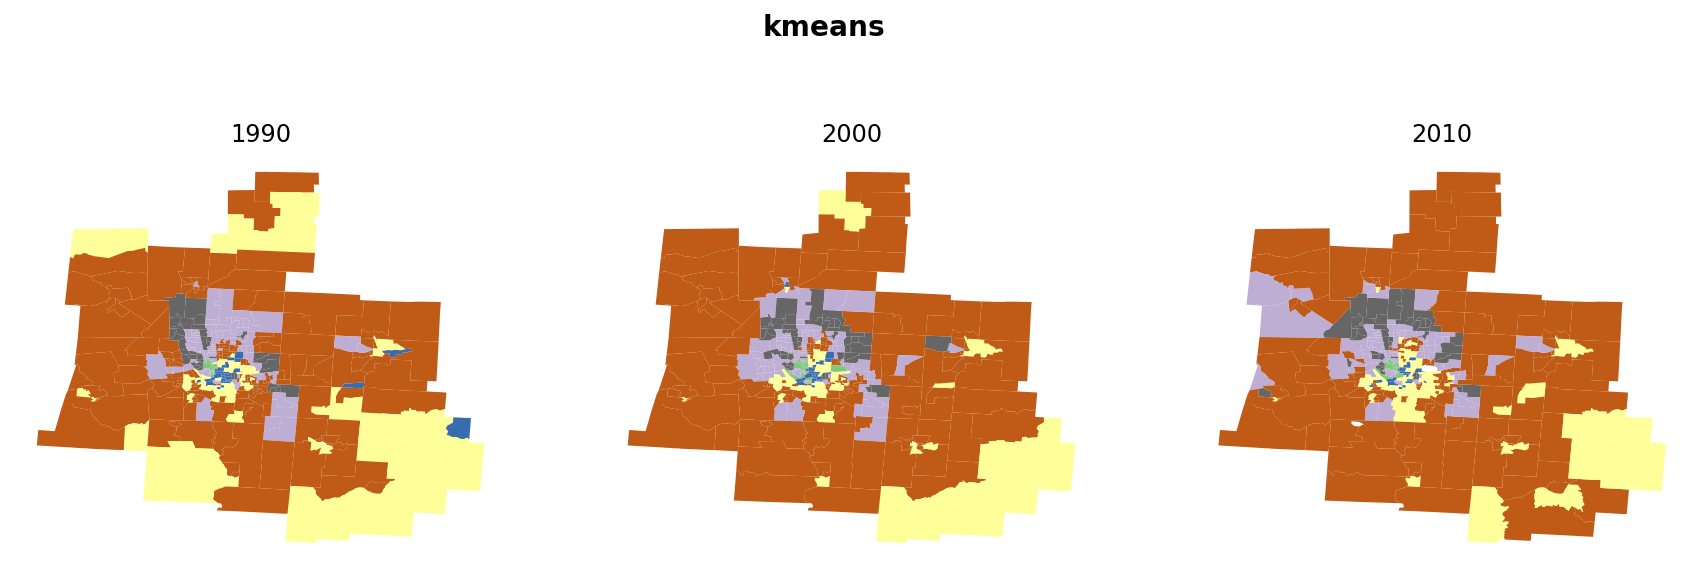

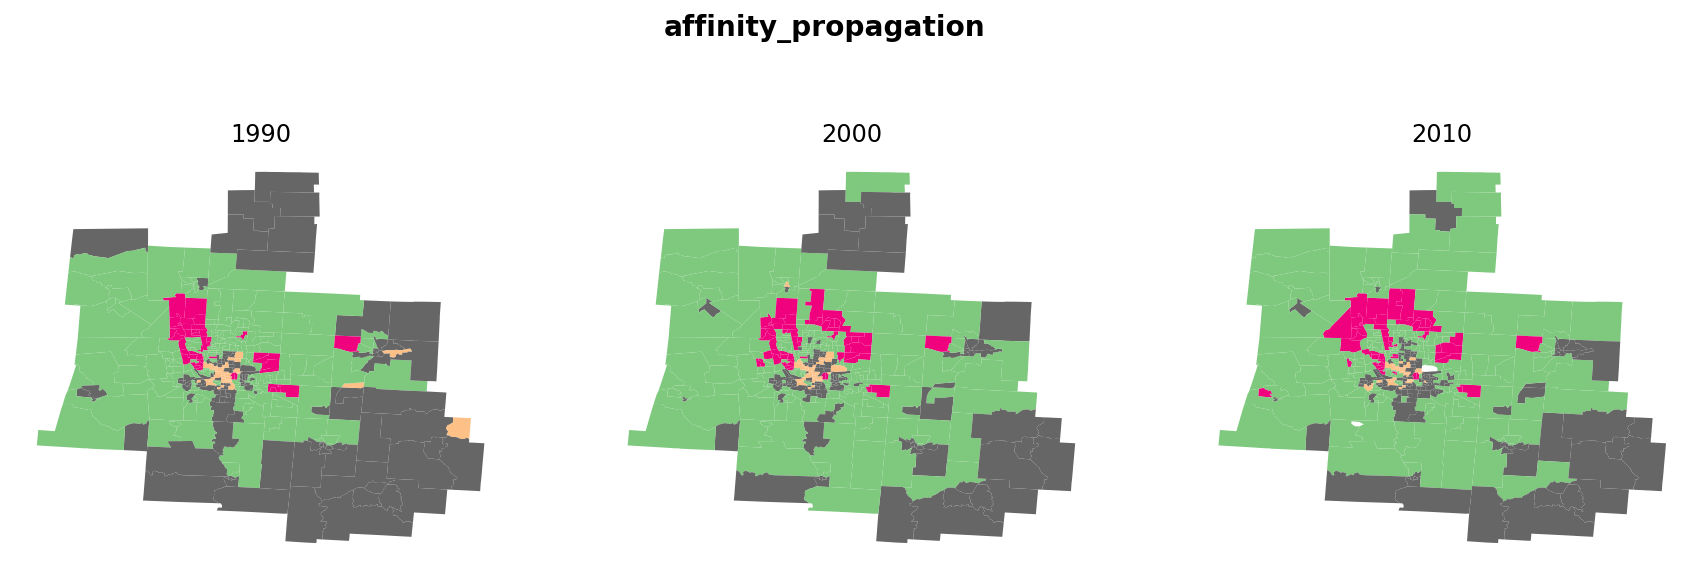

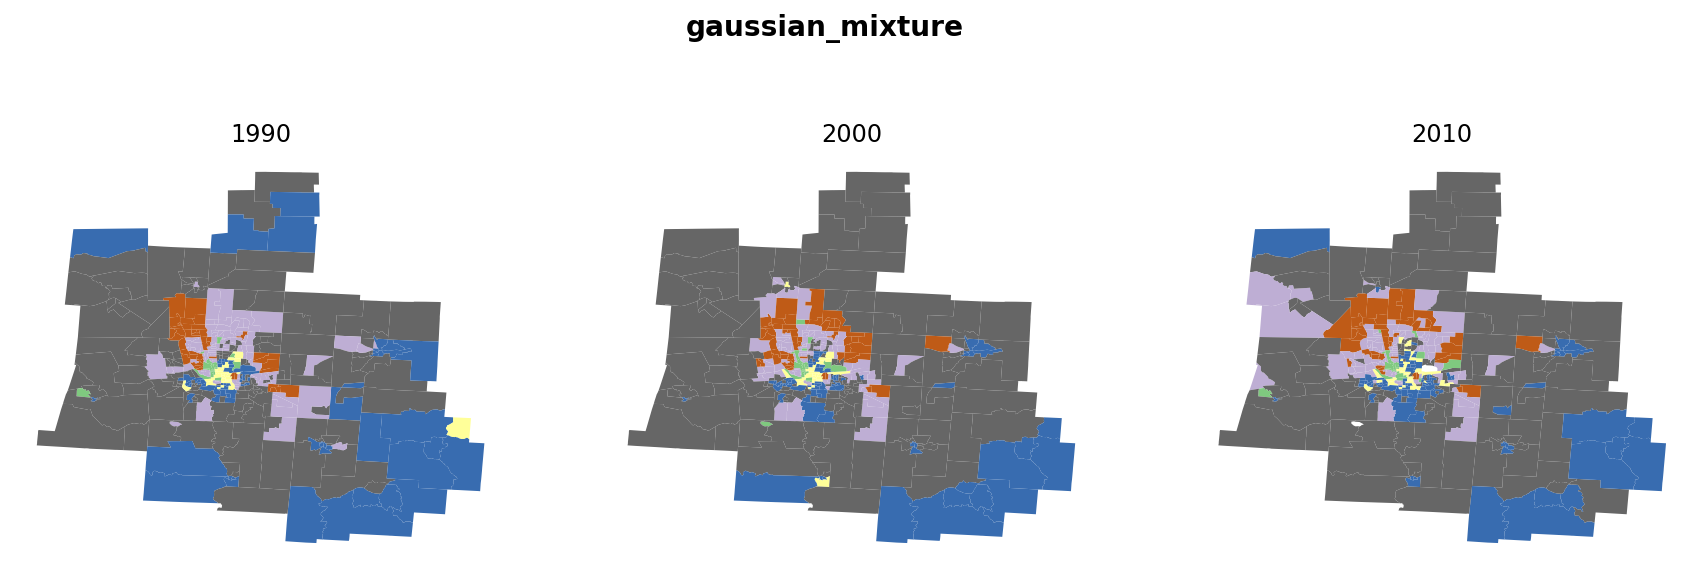

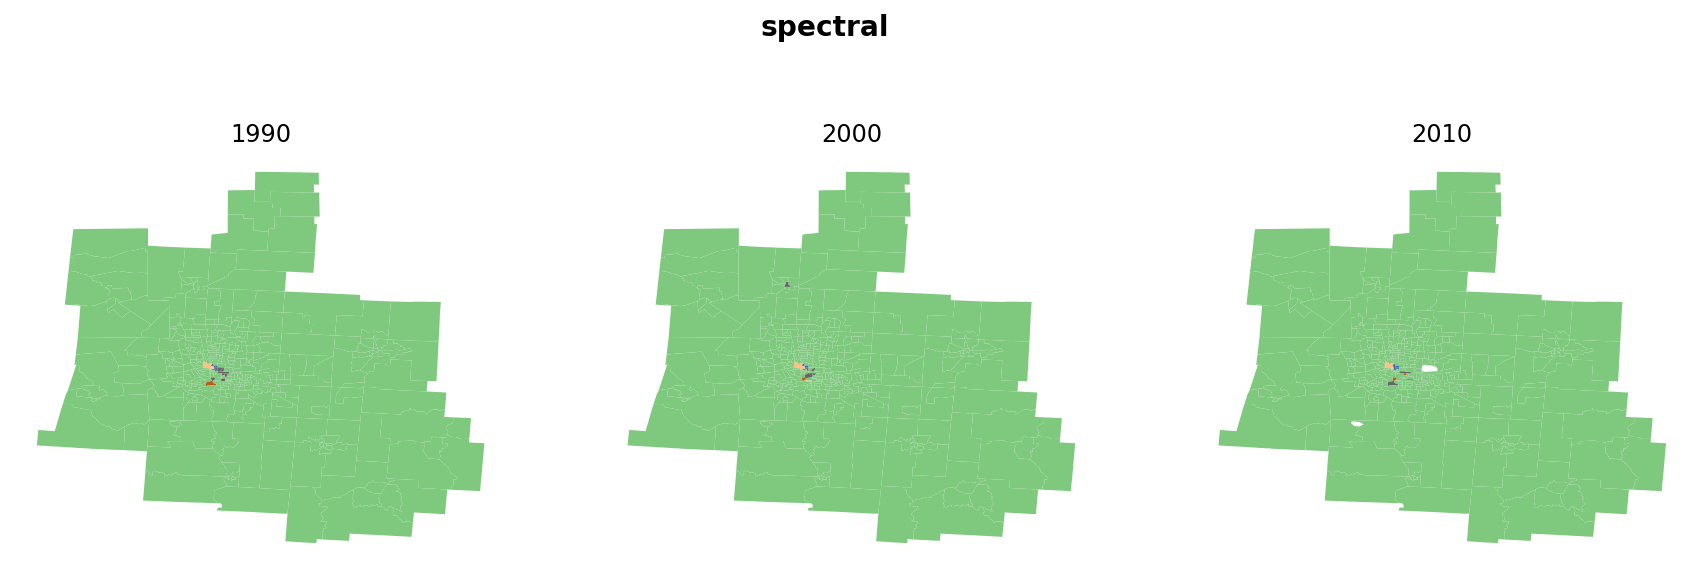

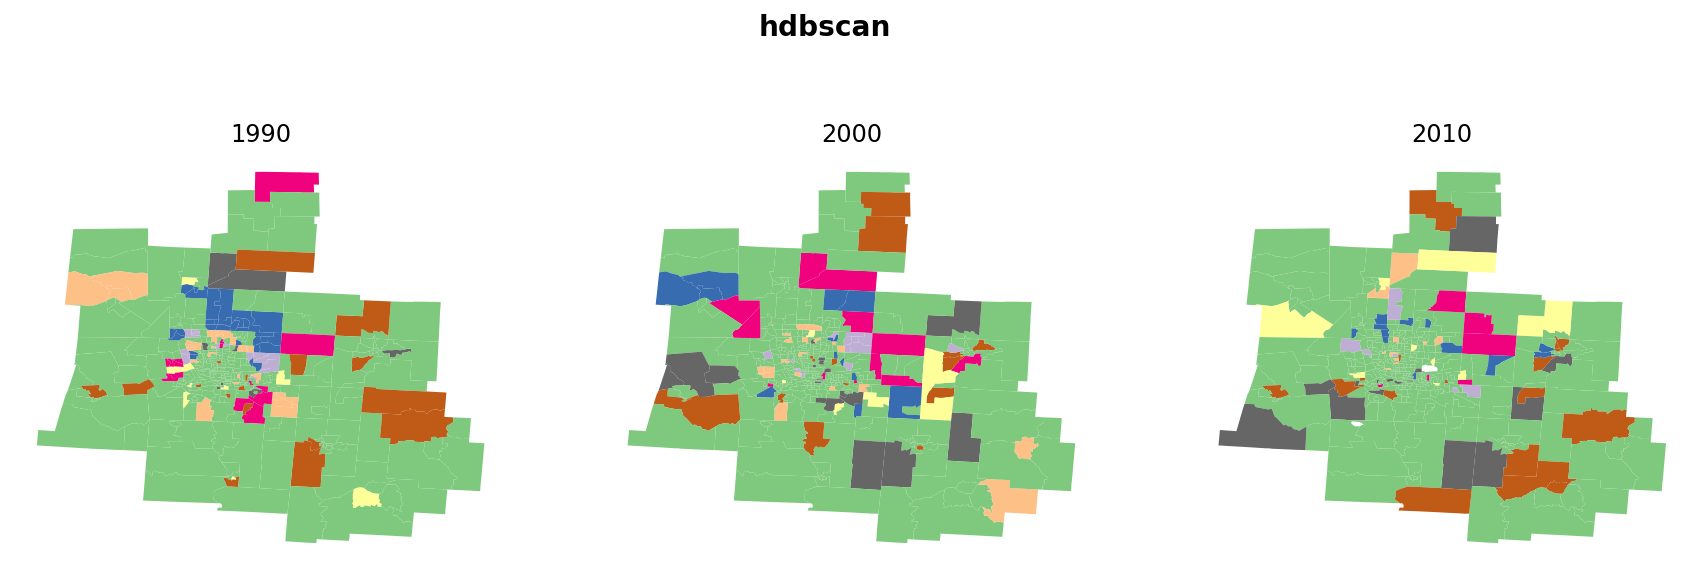

In [11]:
for algo in types:
    
    columbus.cluster(columns=['median_household_income', 'p_poverty_rate', 'p_edu_college_greater', 'p_unemployment_rate'], method=algo)
    plot(columbus, algo, 'Accent')

## Modeling neighborhoods

If use use the `cluster_spatial` method instead of the classic `cluster` method, we adopt the regionalization approach, assuming that each observation in smaller than a single "neighborhood", and aggregate them into bespoke neighborhoods that are internally similar.

Here again, we offer several different spatial clustering algorithms, each of which produces a distinct result

In [12]:
spatial_types = ['azp', 'ward_spatial', 'skater', 'spenc', 'max_p']

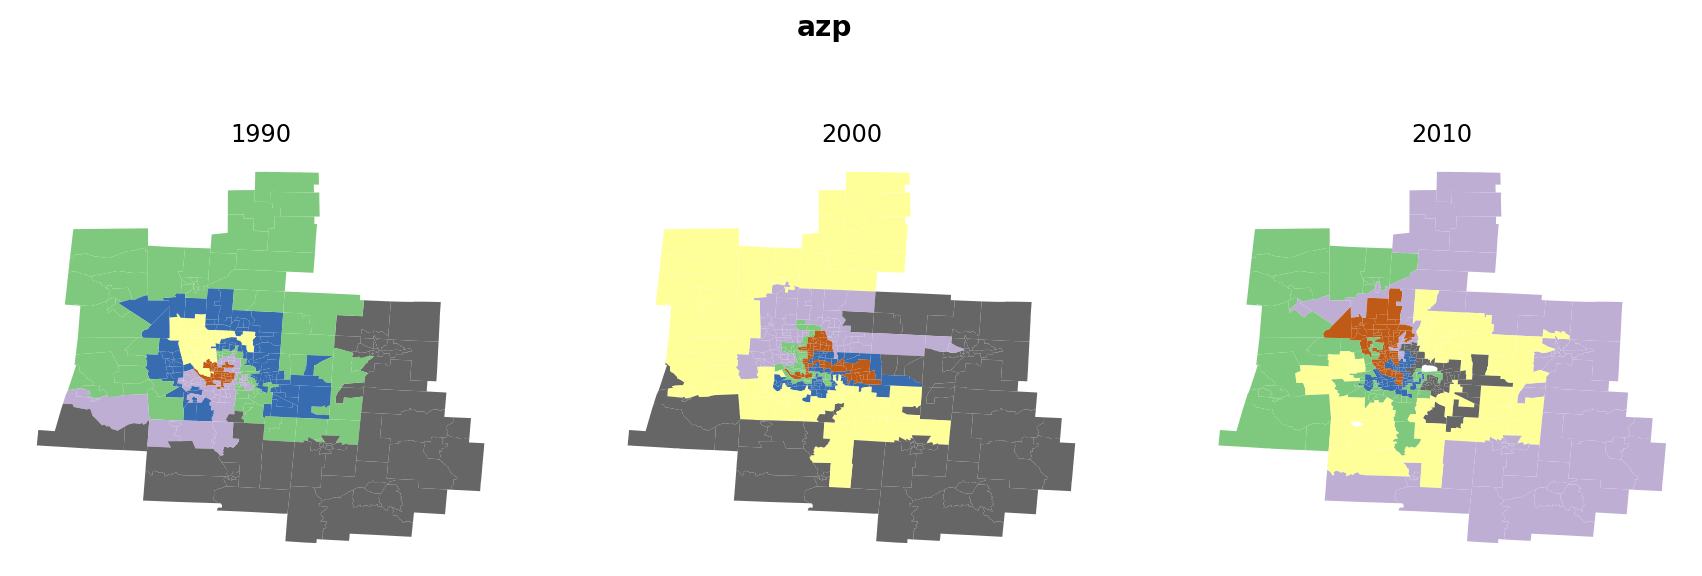

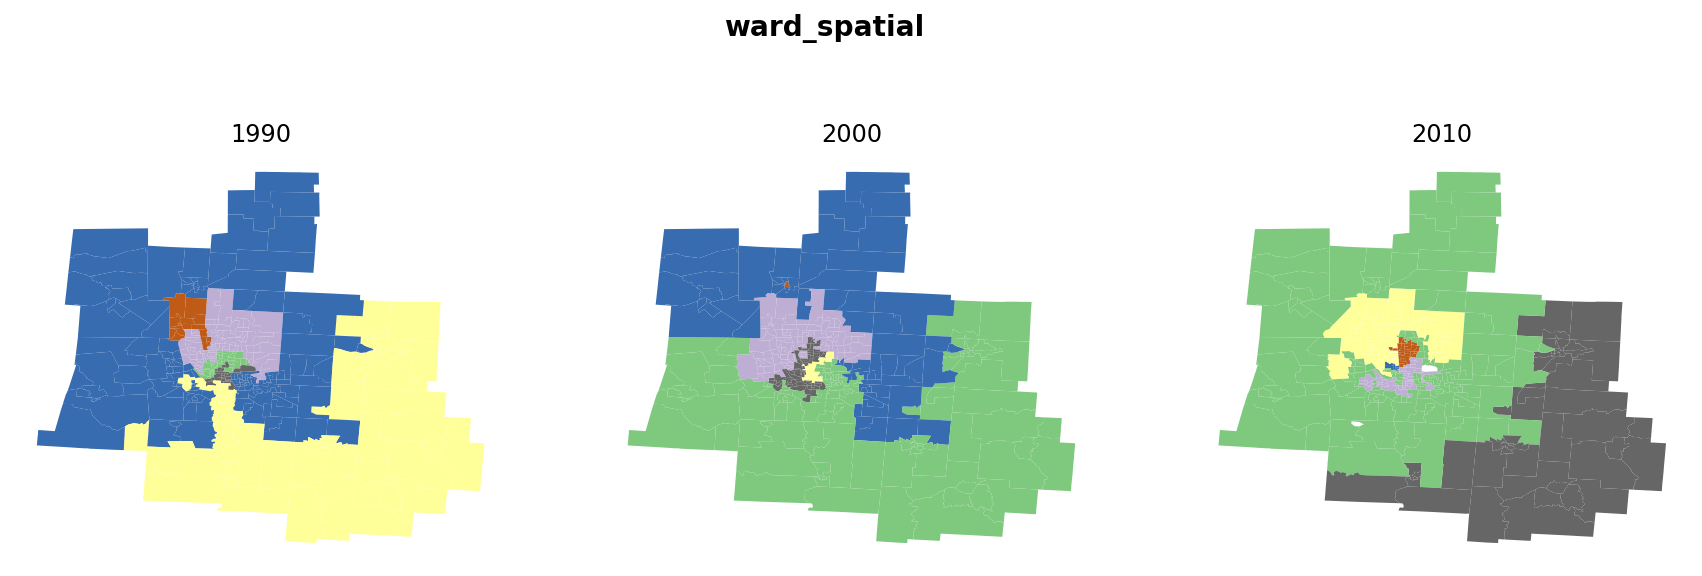

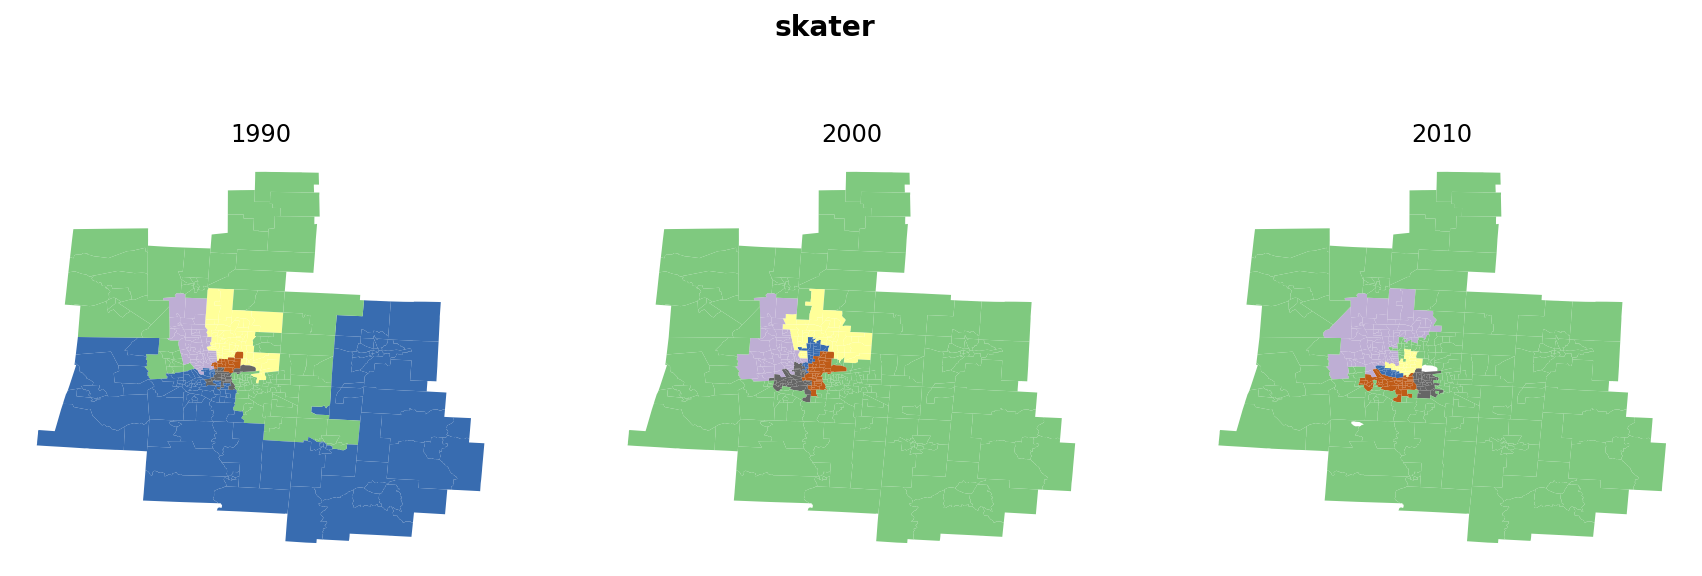

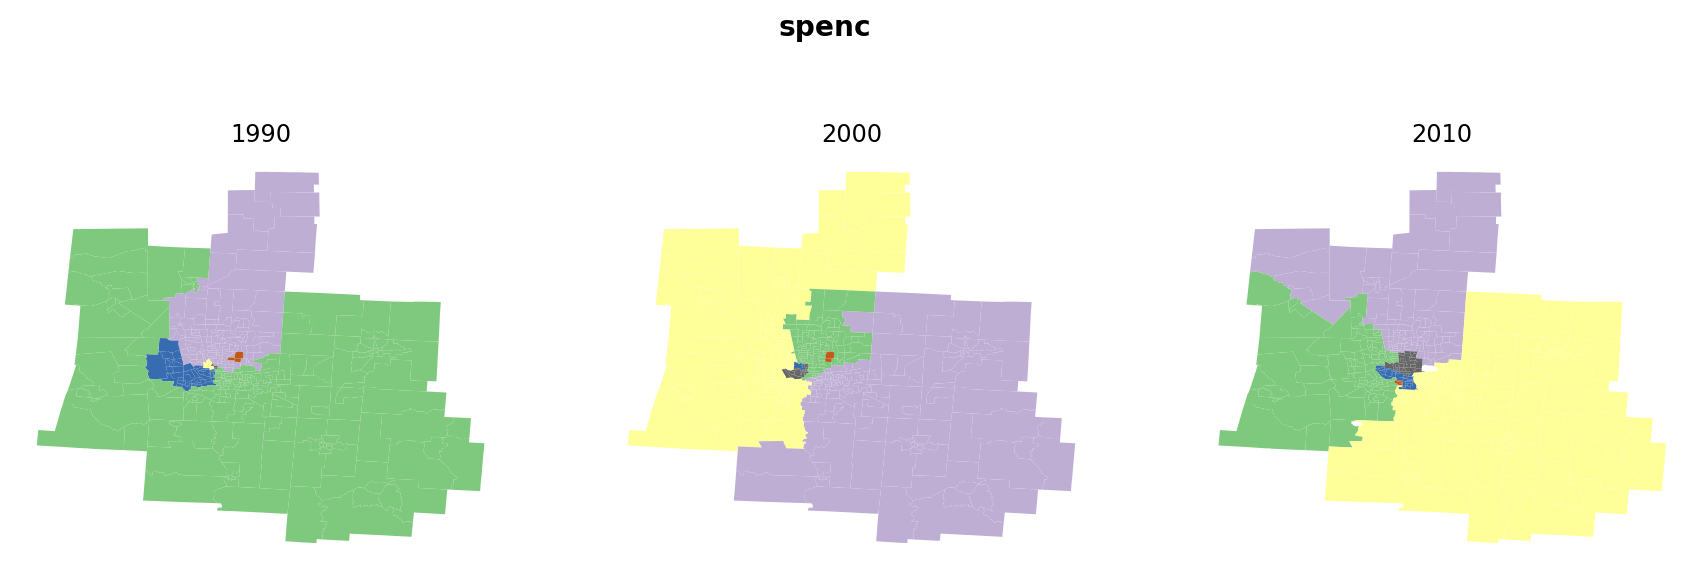

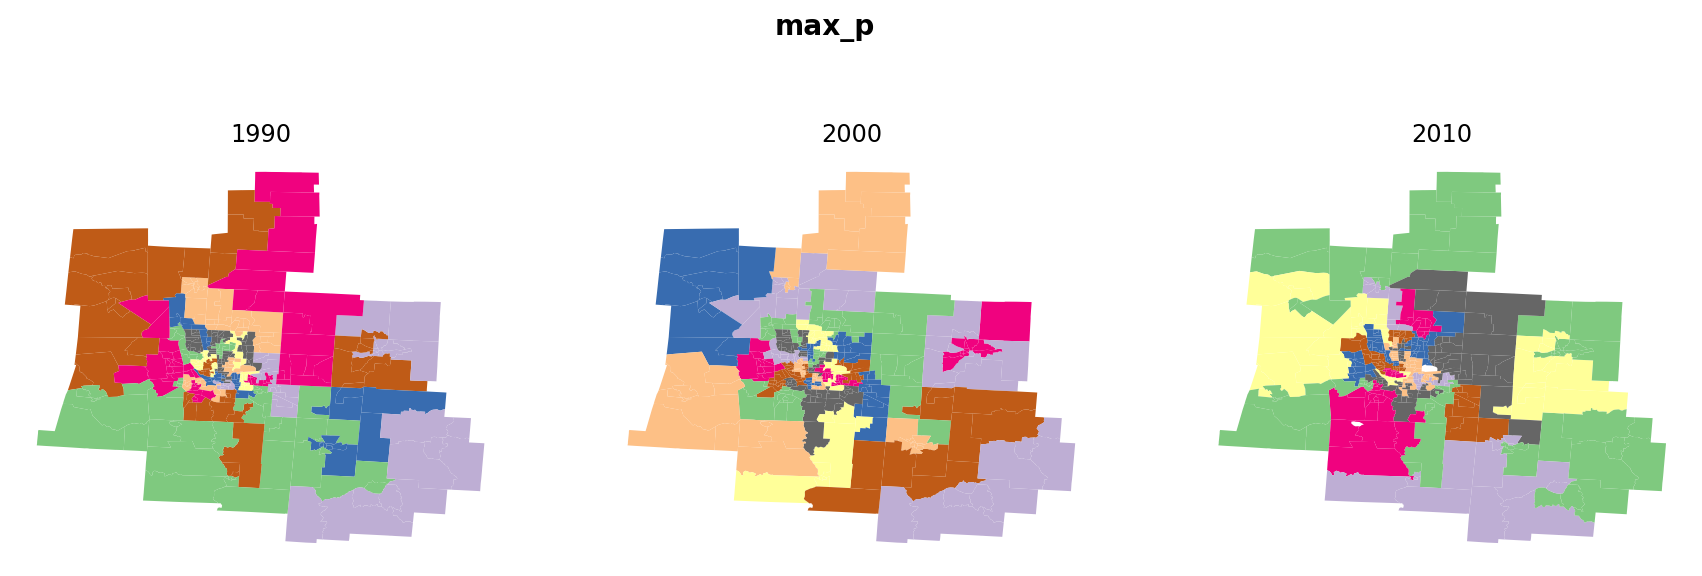

In [13]:
sys.stdout = open(os.devnull, 'w') # Disable printring because of max_p's diagnostics

for algo in spatial_types:
    
    columbus.cluster_spatial(columns=['median_household_income', 'p_poverty_rate', 'p_edu_college_greater', 'p_unemployment_rate'], method=algo)
    plot(columbus, algo, "Accent")